# 01 - Framework

## Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm
import arch as am

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import src

sys.path.append('../../kungfu/')
import kungfu as kf

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

In [6]:
#from src.models import NormalModel
#from src.hmm import HMM
import src

## Load data

In [7]:
df_predictors = pd.read_pickle('../data/external/df_predictors.pkl')
s_dp = df_predictors.dp.asfreq('M')
s_ret = df_predictors['Index'].pct_change().asfreq('M')

In [8]:
s_daily = pd.read_pickle('../data/external/market_daily.pkl').set_obstype('return')
s_monthly = pd.read_pickle('../data/external/market_monthly.pkl').set_obstype('return')

In [9]:
series = s_dp.dropna()

In [10]:
series = s_ret.dropna()

In [11]:
series = s_daily

In [12]:
series = s_monthly

## Compare densities

In [12]:
from sklearn.mixture import GaussianMixture

In [13]:
def fit_gaussian_mixture_distribution(data, K=1):
    
    '''
    MOVE
    '''
    
    # Gaussian mixture model
    gmm = GaussianMixture(n_components=K).fit(data.values.reshape(-1,1))
    
    # Obtain mixture distribution
    mix = src.MixtureDistribution([])
    for (m,s,p) in zip(gmm.means_.flatten(),gmm.covariances_.flatten()**0.5,gmm.weights_):
        mix.add_component(distribution=src.NormalDistribution(mu=m, sigma=s), weight=p)
        
    return mix

def fit_kernel_density_distrbution(data, method='scott'):
    
    '''
    
    '''
    
    # equal weights
    w = 1/data.count()
    
    # scale parameter
    if method == 'scott':
        s = 3.5*data.std()/(data.count()**(1/3))
    if method == 'silverman':
        s = ((4*data.std()**5)/(3*data.count()))**(1/5)
    
    # create mixture
    kde = src.MixtureDistribution(components=[(src.NormalDistribution(mu=m, sigma=s), w) for m in data])
#     kde = GaussianMixtureDistribution([(m,s,w) for m in data])
    return kde

def fit_normal_distribution(data):
    normal = src.NormalDistribution(mu=data.mean(), sigma=data.std())
#     normal = sp.stats.norm(data.mean(),data.std())
    return normal

In [14]:
kde = fit_kernel_density_distrbution(series, method='silverman')
mix2 = fit_gaussian_mixture_distribution(series, K=2)
mix3 = fit_gaussian_mixture_distribution(series, K=3)
mix4 = fit_gaussian_mixture_distribution(series, K=4)
mix5 = fit_gaussian_mixture_distribution(series, K=5)
mix8 = fit_gaussian_mixture_distribution(series, K=8)
mix16 = fit_gaussian_mixture_distribution(series, K=16)
mix32 = fit_gaussian_mixture_distribution(series, K=32)
mix64 = fit_gaussian_mixture_distribution(series, K=64)
normal = fit_normal_distribution(series)
#normal2 = fit_gaussian_mixture_distribution(series, K=1)

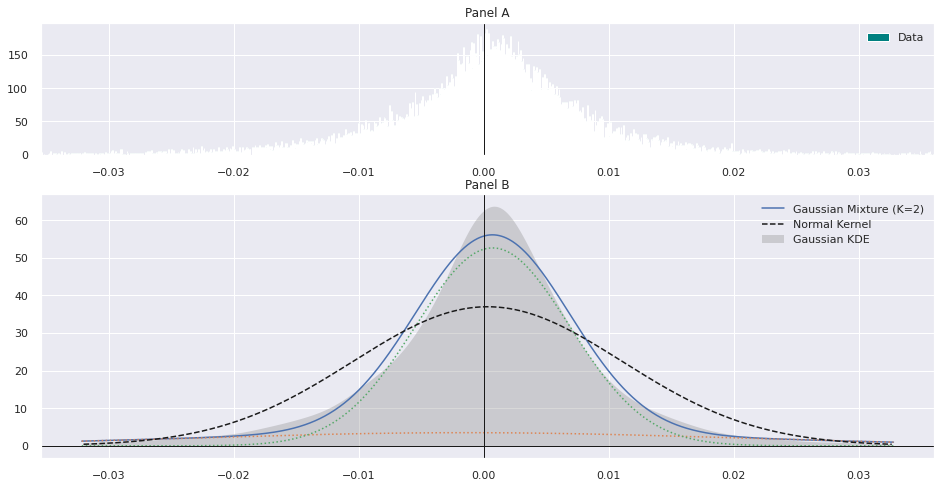

In [15]:
# plot
from src.plots import plot_mixture_components, plot_kernel_density, plot_pdf

#mix = hmm.get_mixture_distribution(state='steady_state')

fig, axes = plt.subplots(2, 1, figsize=[16,8], gridspec_kw={'height_ratios': [1, 2]})

ax = axes[1]
plot_pdf(mix2, ax=ax, label='Gaussian Mixture (K=2)')
plot_mixture_components(mix2, ax=ax)
plot_kernel_density(series, ax=ax, label='Gaussian KDE', color='grey')
plot_pdf(normal, ax=ax, linestyle='--', color='k', label='Normal Kernel')
ax.axhline(0, color='k', linewidth=1)
ax.axvline(0, color='k', linewidth=1)
ax.set_title('Panel B')
ax.legend()

lim = ax.get_xlim()
ax = axes[0]
ax.set_xlim(lim)
ax.hist(series,bins=series.count()//5, color='teal', label='Data')
ax.axvline(0, color='k', linewidth=1)
ax.set_title('Panel A')
ax.legend()

# fig.savefig('../latex/figures/distribution_comparison.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

In [16]:
def kolmogorov_smirnov_test(data, distribution):
    test_statistic = sp.stats.kstest(data, distribution.cdf)[0]
    return test_statistic

def kuipers_test(data, distribution):
    test_statistic = sp.stats.kstest(data, distribution.cdf, alternative='less')[0]\
                        + sp.stats.kstest(data, distribution.cdf, alternative='greater')[0]
    return test_statistic

def distribution_log_likelihood(data, distribution):
    log_likelihood = np.log(distribution.pdf(data)).sum()
    return log_likelihood

In [17]:
def data_stats(data):
    values = [data.mean(),
              data.std(),
              data.skew(),
              data.kurt()-3,
              np.nan,
              np.nan,
             np.nan]
    return values

def comparison_stats(data, distribution):
    values = [distribution.mean(),
              distribution.std(),
              distribution.skew(),
              distribution.exkurt(),
              kolmogorov_smirnov_test(data, distribution),
              kuipers_test(data, distribution),
              distribution_log_likelihood(data, distribution)]
    return values

In [18]:
comparison_table = kf.FinancialDataFrame(columns=['mean','std','skew','exkurt','Kolmogorov-Smirnov','Kuiper\'s test','log-likelihood'])

comparison_table.loc['Data'] = data_stats(series)
comparison_table.loc['Gaussian KDE'] = comparison_stats(series, kde)
comparison_table.loc['Normal Distribution (K=1)'] = comparison_stats(series, normal)
comparison_table.loc['Gaussian Mixture (K=2)'] = comparison_stats(series, mix2)
comparison_table.loc['Gaussian Mixture (K=3)'] = comparison_stats(series, mix3)
comparison_table.loc['Gaussian Mixture (K=4)'] = comparison_stats(series, mix4)
comparison_table.loc['Gaussian Mixture (K=5)'] = comparison_stats(series, mix5)
comparison_table.loc['Gaussian Mixture (K=8)'] = comparison_stats(series, mix8)
comparison_table.loc['Gaussian Mixture (K=16)'] = comparison_stats(series, mix16)
comparison_table.loc['Gaussian Mixture (K=32)'] = comparison_stats(series, mix32)
comparison_table.loc['Gaussian Mixture (K=64)'] = comparison_stats(series, mix64)

comparison_table = comparison_table.replace(np.nan,'')\
                                   .replace(0,'')

#comparison_table.export_to_latex(path='../latex/tables/', filename='distribution_comparison')

comparison_table

,mean,std,skew,exkurt,Kolmogorov-Smirnov,Kuiper's test,log-likelihood
Data,0.0003,0.0108,-0.1603,14.0885,,,
Gaussian KDE,0.0003,0.0109,-0.1557,16.4340,0.0135,0.0252,81874.3095
Normal Distribution (K=1),0.0003,0.0108,,-0.0000,0.0988,0.1938,77052.1145
Gaussian Mixture (K=2),0.0003,0.0108,-0.3210,5.9275,0.0286,0.0531,81392.0231
Gaussian Mixture (K=3),0.0003,0.0108,-0.0910,5.3168,0.0268,0.0478,81390.8209
Gaussian Mixture (K=4),0.0003,0.0108,0.1000,10.3193,0.0323,0.0565,81515.4013
Gaussian Mixture (K=5),0.0003,0.0108,-0.0955,9.2363,0.0118,0.0217,81694.6621
Gaussian Mixture (K=8),0.0003,0.0108,-0.0971,13.5262,0.0126,0.0247,81793.7436
Gaussian Mixture (K=16),0.0003,0.0108,-0.1506,15.9566,0.0094,0.0176,81843.3155
Gaussian Mixture (K=32),0.0003,0.0108,-0.1583,16.7951,0.0091,0.0170,81869.9639


## Forecast Plots

#### Set up model

In [20]:
emission_models = (src.NormalModel(mu=1.1, sigma=0.2), src.NormalModel(mu=1-0.2, sigma=0.3))
transition_matrix = np.matrix([[0.95, 0.05],
                               [0.3, 0.7]])
state_vector = [0.7, 0.3]
hmm = src.HiddenMarkovModel(emission_models=emission_models, transition_matrix=transition_matrix, state_vector=state_vector)

In [19]:
mu_0 = -0.001088091030590657
mu_1 = 0.0007135045295192978
sigma2_0 = 0.00035580049937316557
sigma2_1 = 3.712493137298489e-05
sigma_0 = sigma2_0**0.5
sigma_1 = sigma2_1**0.5
emission_models = (src.NormalModel(mu=mu_0+1, sigma=sigma_0), src.NormalModel(mu=mu_1+1, sigma=sigma_1))

p00 = 0.9578343472909316
p10 = 0.013033813102422378
transition_matrix = [[p00, 1-p00],
                     [p10, 1-p10]]

state_vector = [0.7, 0.3]
hmm = src.HiddenMarkovModel(emission_models=emission_models, transition_matrix=transition_matrix, state_vector=state_vector)

In [20]:
hmm.fit(series)

../src/hmm.py:183: RuntimeWarning: divide by zero encountered in log
  score = np.log((B * Gamma).sum(axis=1)).sum(axis=0)
../src/hmm.py:222: RuntimeWarning: divide by zero encountered in double_scalars
  c_0 = 1/alpha_0.sum()
../src/hmm.py:225: RuntimeWarning: invalid value encountered in multiply
  Alpha = alpha_0*c_0
../src/hmm.py:123: UserWarning: maximum number of iterations reached
  warnings.warn('maximum number of iterations reached')
../src/hmm.py:353: UserWarning: Transition matrix rounded to 6 decimal places
  warnings.warn('Transition matrix rounded to 6 decimal places')


AssertionError: transition matrix rows need to sum to one

In [23]:
hmm.transition_matrix

array([[0.95783435, 0.04216565],
       [0.01303381, 0.98696619]])

In [24]:
hmm.component_means(), hmm.component_stds()

([0.9989119089694093, 1.0007135045295192],
 [0.018862674767200053, 0.006093023171873294])

In [25]:
hmm.state_vector

array([[0.7, 0.3]])

In [26]:
hmm.steady_state()

array([0.23612209, 0.76387791])

### Plot

In [27]:
# plot parameters
state_names = ['SS','S0','S1']
H = 100
pdf_horizons = np.arange(13)
pdf_horizons = [0,1,5,10,25,50,75,100]#[0,1,5,10,15,21,31,42,63,126,189,252]:

# model states
hmm_ss = hmm.copy()
hmm_ss.steady_state(set_state=True)

hmm_0 = hmm.copy()
hmm_0.state_vector = [1, 0]

hmm_1 = hmm.copy()
hmm_1.state_vector = [0, 1]

hmms = [hmm_ss, hmm_0, hmm_1]

../src/markov.py:122: UserWarning: state vector probabilities rounded to 8 digits
  warnings.warn('state vector probabilities rounded to 8 digits')
../src/markov.py:122: UserWarning: state vector probabilities rounded to 8 digits
  warnings.warn('state vector probabilities rounded to 8 digits')
../src/markov.py:122: UserWarning: state vector probabilities rounded to 8 digits
  warnings.warn('state vector probabilities rounded to 8 digits')
../src/markov.py:122: UserWarning: state vector probabilities rounded to 8 digits
  warnings.warn('state vector probabilities rounded to 8 digits')
../src/markov.py:122: UserWarning: state vector probabilities rounded to 8 digits
  warnings.warn('state vector probabilities rounded to 8 digits')
../src/markov.py:122: UserWarning: state vector probabilities rounded to 8 digits
  warnings.warn('state vector probabilities rounded to 8 digits')
../src/markov.py:122: UserWarning: state vector probabilities rounded to 8 digits
  warnings.warn('state vector 

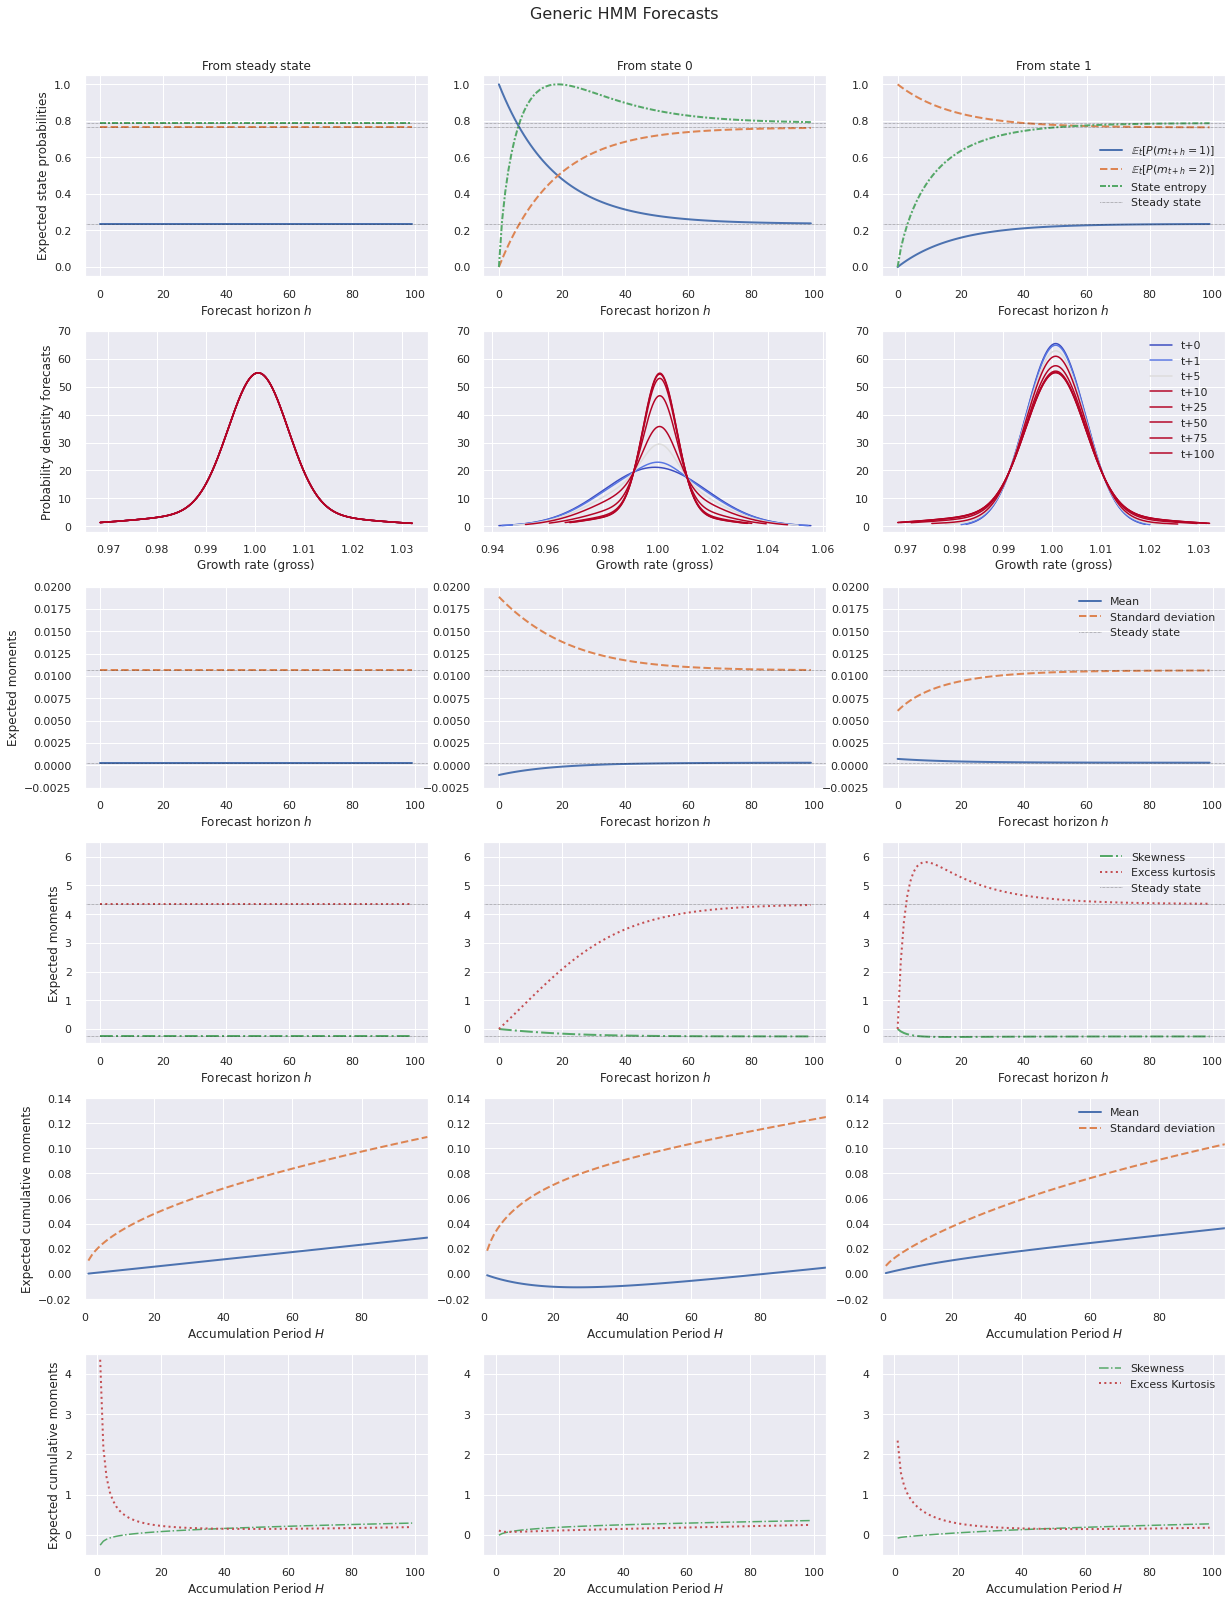

Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode


In [29]:
from src.plots import plot_pdf

fig, axes = plt.subplots(6, 3, figsize=[17,22])
colormap = plt.cm.get_cmap('coolwarm')

i = 0
for hmm in hmms:
    # state variable
    ax = axes[0,i]
    ax.set_ylim([-0.05,1.05])
    ax.plot([hmm.iterate(h).state_vector.squeeze()[0] for h in range(H)], linewidth=2, linestyle='-', label='$\mathbb{E}_t[P(m_{t+h}=1)]$')
    ax.plot([hmm.iterate(h).state_vector.squeeze()[1] for h in range(H)], linewidth=2, linestyle='--', label='$\mathbb{E}_t[P(m_{t+h}=2)]$')
    ax.plot([hmm.iterate(h).entropy() for h in range(H)], linewidth=2, linestyle=(0, (3, 1, 1, 1)), label='State entropy')
    ax.axhline(hmm.steady_state()[0], color='k', linewidth=0.5, linestyle=':', label='Steady state')
    ax.axhline(hmm.steady_state()[1], color='k', linewidth=0.5, linestyle=':')
    ax.axhline(hmm_ss.entropy(), color='k', linewidth=0.5, linestyle=':')
    ax.set_xlabel('Forecast horizon $h$')
    if i == 0:
        ax.set_ylabel('Expected state probabilities')
    if i == 2:
        ax.legend()
    
    # pdfs
    ax = axes[1,i]
    ax.set_ylim([-2, 70])
    for h in pdf_horizons:
        plot_pdf(hmm.iterate(h).distribution, ax=ax, label='t+'+str(h), color=colormap(1/10*h), linewidth=1.5)
        ax.set_xlabel('Growth rate (gross)')
    if i == 0:
        ax.set_ylabel('Probability denstity forecasts')
    if i == 2:
        ax.legend()
    
    # mean & std
    ax = axes[2,i]
    ax.set_ylim([-0.0025, 0.02])
    ax.plot([hmm.iterate(h).mean()-1 for h in range(H)], linewidth=2, linestyle='-', label='Mean')
    ax.plot([hmm.iterate(h).std() for h in range(H)], linewidth=2, linestyle='--', label='Standard deviation')
    ax.axhline(hmm_ss.mean()-1, color='k', linewidth=0.5, linestyle=':', label='Steady state')
    ax.axhline(hmm_ss.std(), color='k', linewidth=0.5, linestyle=':')
    ax.set_xlabel('Forecast horizon $h$')
    if i == 0:
        ax.set_ylabel('Expected moments')
    if i == 2:
        ax.legend()
    
    # skew & kurt
    ax = axes[3,i]
    ax.set_ylim([-0.5, 6.5])
    ax.plot(np.nan)
    ax.plot(np.nan)
    ax.plot([hmm.iterate(h).skew() for h in range(H)], linewidth=2, linestyle='-.', label='Skewness')
    ax.plot([hmm.iterate(h).exkurt() for h in range(H)], linewidth=2, linestyle=':', label='Excess kurtosis')
    ax.axhline(hmm_ss.skew(), color='k', linewidth=0.5, linestyle=':', label='Steady state')
    ax.axhline(hmm_ss.exkurt(), color='k', linewidth=0.5, linestyle=':')
    ax.set_xlabel('Forecast horizon $h$')
    if i == 0:
        ax.set_ylabel('Expected moments')
    if i == 2:
        ax.legend()
    
    # product mean & std
    ax = axes[4,i]
    ax.set_xlim([0-0.1,H-0.9])
    ax.set_ylim([-0.02, 0.14])
    ax.plot([np.nan]+[hmm.product_distribution(h).mean()-1 for h in range(1,H)], linewidth=2, linestyle='-', label='Mean')
    ax.plot([np.nan]+[hmm.product_distribution(h).std() for h in range(1,H)], linewidth=2, linestyle='--', label='Standard deviation')
    ax.set_xlabel('Accumulation Period $H$')
    if i == 0:
        ax.set_ylabel('Expected cumulative moments')
    if i == 2:
        ax.legend()
    
    # product skew & kurt
    ax = axes[5,i]
    #ax.set_xlim([0-0.1,H-0.9])
    ax.set_ylim([-0.5, 4.5])
    ax.plot(np.nan)
    ax.plot(np.nan)
    ax.plot([np.nan]+[hmm.product_distribution(h).skew() for h in range(1,H)], linestyle='-.', label='Skewness')
    ax.plot([np.nan]+[hmm.product_distribution(h).exkurt() for h in range(1,H)], linewidth=2, linestyle=':', label='Excess Kurtosis')
    ax.set_xlabel('Accumulation Period $H$')
    if i == 0:
        ax.set_ylabel('Expected cumulative moments')
    if i == 2:
        ax.legend()
    
    i += 1

axes[0,0].set_title('From steady state')
axes[0,1].set_title('From state 1')
axes[0,2].set_title('From state 2')

fig.suptitle('Generic HMM Forecasts', y=1.01, fontsize=16)

fig.tight_layout()

plt.show()

fig.savefig('../latex/figures/generic_forecast.pdf', format='pdf', dpi=200, bbox_inches='tight')

## LEGACY

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as ss
import math
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import sklearn.mixture as mix
import datetime as dt

import mypack.plot as plot
import mypack.calc as calc
import mypack.clas as clas
import mypack.data as data

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [ ]:
sns.set() # sets matplotlib style
sns.set(rc={'figure.figsize': (17, 6)})

In [ ]:
%matplotlib inline

## Import data

In [ ]:
df_market = pd.read_pickle('df_ts_estimates.pkl')

In [ ]:
df_daily = data.download_factor_data('D')['Mkt-RF']/100
#factors_monthly = data.download_factor_data('M')/100

## Shape of a Gaussian mixture

In [ ]:
# inputs
mixture = clas.MixtureDistribution([])
mixture.add_component((-0.0015, 0.02, 0.3))
mixture.add_component((0.00075, 0.005, 0.7))
#mixture.add_component((-0.0013678325990907631, 0.020811215687394986, 0.19183567056256604))
#mixture.add_component((0.0006879740776781325, 0.0061089838682783365, 1-0.19183567056256604))

In [ ]:
# calculations
mus,sigmas,ps = [],[],[]
mus += [m for (m,s,p) in mixture.components]
sigmas += [s for (m,s,p) in mixture.components]
ps += [p for (m,s,p) in mixture.components]

x = np.linspace(min(mus)-3*max(sigmas), max(mus)+3*max(sigmas), 201)

ys = []
y_mix = np.zeros(201)
for (m,s,p) in mixture.components:
    ys += [p*sp.stats.norm.pdf(x, m, s)]
    y_mix += p*sp.stats.norm.pdf(x, m, s)

In [ ]:
# labels
(m,v,s,k) = mixture.mvsk()
mix_label = 'Mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture.components,range(0,mixture.n_components))]

In [ ]:
#plot
fig,ax = plt.subplots(1,1,figsize=[17,6])
#ax.axhline(0, color='k', linewidth=0.5)
ax.plot(x, y_mix, label=mix_label, linewidth=2)
ax.plot(x, ys[0], label=com_labels[0], linestyle='--', linewidth=2)
ax.plot(x, ys[1], label=com_labels[1], linestyle='-.', linewidth=2)
if len(ys) > 2:
    for iComp in range(2,len(ys)):
        ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Probability density: Mixture distribution of two normal components')
plt.show()

#fig.savefig('mixtureDistributionPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

## Gaussian Mixture Model

In [ ]:
n_components=2

In [ ]:
# data
y = df_daily

# create kernel density estimate
kerneldensity  = sp.stats.gaussian_kde(y)
(m,v,s,k) = (y.mean(), y.var(), y.skew(), y.kurtosis())
kernel_label = 'Empirical kernel density ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'

In [ ]:
# estimate mixture (from Gaussian mixture model)
mix_model = mix.GaussianMixture(n_components).fit(y.values.reshape(-1, 1))
mixture_gmm = clas.MixtureDistribution([])
for (m,s,p) in zip(mix_model.means_.flatten(),mix_model.covariances_.flatten()**0.5,mix_model.weights_):
    mixture_gmm.add_component((m,s,p))

(m,v,s,k) = mixture_gmm.mvsk()
mix_label = 'Gaussian mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_gmm.components,range(0,mixture_gmm.n_components))]

In [ ]:
# calculations
mus,sigmas,ps = [],[],[]
mus += [m for (m,s,p) in mixture_gmm.components]
sigmas += [s for (m,s,p) in mixture_gmm.components]
ps += [p for (m,s,p) in mixture_gmm.components]

x = np.linspace(min(mus)-3*max(sigmas), max(mus)+3*max(sigmas), 201)

y_normal = sp.stats.norm.pdf(x, y.mean(), y.var()**0.5)
normal_label = 'Normal distribution ( μ='+'{:0.4f}'.format(y.mean())+', σ='+'{:0.4f}'.format(y.var()**0.5)+' )'

ys = []
y_mix = np.zeros(201)
for (m,s,p) in mixture_gmm.components:
    ys += [p*sp.stats.norm.pdf(x, m, s)]
    y_mix += p*sp.stats.norm.pdf(x, m, s)

In [ ]:
# labels
(m,v,s,k) = mixture_gmm.mvsk()
mix_label = 'Mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_gmm.components,range(0,mixture_gmm.n_components))]

In [ ]:
#plot
fig,ax = plt.subplots(1,1,figsize=[17,6])
#ax.axhline(0, color='k', linewidth=0.5)

ax.fill_between(x, kerneldensity(x), linewidth=0, alpha=0.3)#, color='#b6c4db'
ax.plot(x, y_mix, label=mix_label, linewidth=2)
ax.plot(x, kerneldensity(x), label=kernel_label, linewidth=2, linestyle='-.')
ax.plot(x, y_normal, label=normal_label, linestyle='--', linewidth=2)

for iComp in range(0,len(ys)):
    ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
        
#ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Kernel density estimate and Gaussian Mixture Model estimate of daily market excess return data')
plt.show()

#fig.savefig('gaussianMixtureModelDistributionPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [ ]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
color = pd.DataFrame(mix_model.predict_proba(y.values.reshape(-1, 1)))[1]
size = 2#color*10
scat = ax.scatter(y.index, y, c=color, cmap=colormap, s=size, rasterized=True)#, linewidths=0.2, edgecolor='k')
ax.set_ylabel('Excess return')
ax.set_title('Market excess return component probability from Gaussian Mixture Model estimate')
cbar = ax.figure.colorbar(scat, pad=0.01)
cbar.set_label('Component probability')
plt.show()

#fig.savefig('gaussianMixtureModelClassificationPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

## Trends in the data

In [ ]:
colormap = plt.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
color = ((y.rolling(22).mean()<y.rolling(22).mean().quantile(0.2)).astype(int)-(y.rolling(22).mean()>y.rolling(22).mean().quantile(0.8)))/2+0.5
ax.scatter(y.index, y, c=color, cmap=colormap, s=(color-0.5).abs()*2+0.5)
ax.set_title('Short-term trends')

plt.show()

In [ ]:
colormap = plt.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
#ax.scatter(y.index, y, c=hmm_model.smoothed_marginal_probabilities[0], cmap=colormap, s=hmm_model.smoothed_marginal_probabilities[0]*2+0.2)
color = ((y**2).rolling(22).mean()>(y**2).rolling(22).mean().quantile(0.8))
size = color+0.5
ax.scatter(y.index, y, c=color, cmap=colormap, s=size)
ax.set_title('Volatility clusters')

plt.show()

## Hidden Markov Model

In [ ]:
# data
y = df_daily

# create kernel density estimate
kerneldensity  = sp.stats.gaussian_kde(y)
(m,v,s,k) = (y.mean(), y.var(), y.skew(), y.kurtosis())
kernel_label = 'Empirical kernel density ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'

In [ ]:
# estimate mixture (from Hidden Markov Model)
hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=[0.95,0.02,m,m,v*2,v/2], method='powell', disp=False)
(mu_0, mu_1) = hmm_model.params.values[2:4]
(sigma_0, sigma_1) = hmm_model.params.values[4:6]**0.5
(p0, p1) = hmm_model.smoothed_marginal_probabilities.mean().values
mixture_hmm = clas.MixtureDistribution([(mu_0, sigma_0, p0),(mu_1, sigma_1, p1)])

(m,v,s,k) = mixture_hmm.mvsk()
mix_label = 'Gaussian mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_hmm.components,range(0,mixture_hmm.n_components))]

In [ ]:
# calculations
mus,sigmas,ps = [],[],[]
mus += [m for (m,s,p) in mixture_hmm.components]
sigmas += [s for (m,s,p) in mixture_hmm.components]
ps += [p for (m,s,p) in mixture_hmm.components]

x = np.linspace(min(mus)-3*max(sigmas), max(mus)+3*max(sigmas), 201)

y_normal = sp.stats.norm.pdf(x, y.mean(), y.var()**0.5)
normal_label = 'Normal distribution ( μ='+'{:0.4f}'.format(y.mean())+', σ='+'{:0.4f}'.format(y.var()**0.5)+' )'

ys = []
y_mix = np.zeros(201)
for (m,s,p) in mixture_hmm.components:
    ys += [p*sp.stats.norm.pdf(x, m, s)]
    y_mix += p*sp.stats.norm.pdf(x, m, s)

In [ ]:
# labels
(m,v,s,k) = mixture_hmm.mvsk()
mix_label = 'Mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_hmm.components,range(0,mixture_hmm.n_components))]

In [ ]:
#plot
fig,ax = plt.subplots(1,1,figsize=[17,6])
#ax.axhline(0, color='k', linewidth=0.5)

ax.fill_between(x, kerneldensity(x), linewidth=0, alpha=0.3)#, color='#b6c4db'
ax.plot(x, y_mix, label=mix_label, linewidth=2)
ax.plot(x, kerneldensity(x), label=kernel_label, linewidth=2, linestyle='-.')
ax.plot(x, y_normal, label=normal_label, linestyle='--', linewidth=2)

for iComp in range(0,len(ys)):
    ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
        
#ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Kernel density estimate and Hidden Markov Model estimate of daily market excess return data')
plt.show()

#fig.savefig('hiddenMarkovModelDistributionPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [ ]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
color = hmm_model.smoothed_marginal_probabilities[1]
color = hmm_model.filtered_marginal_probabilities[1]
size = 2#(color+5)
scat = ax.scatter(y.index, y, c=color, cmap=colormap, s=size, rasterized=True)#, linewidths=0.2, edgecolor='k')
ax.set_ylabel('Excess return')
ax.set_title('Market excess return regime probability from Hidden Markov Model estimate')
cbar = ax.figure.colorbar(scat, pad=0.01)
cbar.set_label('Filtered regime probability')
plt.show()

#fig.savefig('hiddenMarkovModelClassificationPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [ ]:
p00 = hmm_model.params.values[0]
p10 = hmm_model.params.values[1]
transition_matrix = [[p00, 1-p00],
                     [p10, 1-p10]]
mc = clas.MarkovChain(transition_matrix)
steady_state = mc.calculate_steady_state()
expected_durations = mc.calculate_expected_durations()
#steady_state = calc.calculate_steady_state_probabilities(transition_matrix)

hmm_parameter_table = pd.DataFrame(index=['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$','$\sigma_0$','$\sigma_1$','$P_{SS}[S=0]$','$P_{SS}[S=1]$','Exp. duration state 0','Exp. duration state 1'],columns=['estimate','s.e.'])

hmm_parameter_table.loc[['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$'],'estimate'] = hmm_model.params.values[0:4]
hmm_parameter_table.loc[['$\sigma_0$','$\sigma_1$'],'estimate'] = hmm_model.params.values[4:6]**0.5

hmm_parameter_table.loc[['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$'],'s.e.'] = hmm_model.bse.values[0:4]
hmm_parameter_table.loc[['$\sigma_0$','$\sigma_1$'],'s.e.'] = hmm_model.bse.values[4:6]**0.5

hmm_parameter_table.loc[['$P_{SS}[S=0]$','$P_{SS}[S=1]$'],'estimate'] = steady_state
hmm_parameter_table.loc[['Exp. duration state 0','Exp. duration state 1'],'estimate'] = expected_durations

hmm_parameter_table[hmm_parameter_table.isna()] = ''
hmm_parameter_table

#calc.export_df_to_latex(hmm_parameter_table, 'hmm_parameter_table')

## Model Comparison

In [ ]:
w = 1/y.count()
#s = ((4*y.std()**5)/(3*y.count()))**(1/5) #silverman's rule
s = 3.5*y.std()/(y.count()**(1/3)) #scott's rule
kde = clas.MixtureDistribution([(m,s,w) for m in y])

distribution_tests_table = pd.DataFrame(index=['Gaussian Kernel','Gaussian Mixture Model','Hidden Markov Model','Normal Distribution'],columns=['Kolmogorov-Smirnov','Kuiper\'s test'])

distribution_tests_table.loc['Gaussian Kernel','Kolmogorov-Smirnov'] = sp.stats.kstest(y, kde.cdf)[0]
distribution_tests_table.loc['Gaussian Mixture Model','Kolmogorov-Smirnov'] = sp.stats.kstest(y, mixture_gmm.cdf)[0]
distribution_tests_table.loc['Hidden Markov Model','Kolmogorov-Smirnov'] = sp.stats.kstest(y, mixture_hmm.cdf)[0]
distribution_tests_table.loc['Normal Distribution','Kolmogorov-Smirnov'] = sp.stats.kstest(y, sp.stats.norm(y.mean(),y.std()).cdf)[0]

distribution_tests_table.loc['Gaussian Kernel','Kuiper\'s test'] = sp.stats.kstest(y, kde.cdf, alternative='less')[0] + sp.stats.kstest(y, kde.cdf, alternative='greater')[0]
distribution_tests_table.loc['Gaussian Mixture Model','Kuiper\'s test'] = sp.stats.kstest(y, mixture_gmm.cdf, alternative='less')[0] + sp.stats.kstest(y, mixture_gmm.cdf, alternative='greater')[0]
distribution_tests_table.loc['Hidden Markov Model','Kuiper\'s test'] = sp.stats.kstest(y, mixture_hmm.cdf, alternative='less')[0] + sp.stats.kstest(y, mixture_hmm.cdf, alternative='greater')[0]
distribution_tests_table.loc['Normal Distribution','Kuiper\'s test'] = sp.stats.kstest(y, sp.stats.norm(y.mean(),y.std()).cdf, alternative='less')[0] + sp.stats.kstest(y, sp.stats.norm(y.mean(),y.std()).cdf, alternative='greater')[0]

calc.export_df_to_latex(distribution_tests_table, 'distribution_tests_table')

distribution_tests_table

# OLD CODE

In [ ]:
%%time
start_params=[0.95,0.02,0.02,0.02,#0.02,
              0.02,0.95,0.02,0.02,#0.02,
              0.02,0.02,0.95,0.02,#0.02,
              #0.02,0.02,0.02,0.95,0.02,
              m,m,m,m,
              v*2,v/2,v,v]

hmm_model = sm.tsa.MarkovRegression(y, k_regimes=4, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=start_params, method='powell', disp=False)
hmm_model.summary()